In [ ]:
# Core
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Time series
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

# ML
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

# DL
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Utils
import warnings
warnings.filterwarnings("ignore")


In [ ]:
colors = ['#F2A900', '#3C3C3D', '#E50914', '#B20710', '#F5F5F1']
sns.set_palette(sns.color_palette(colors))

# Matplotlib Params for Clean Plots
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['axes.edgecolor'] = '#333F4B'
plt.rcParams['axes.linewidth'] = 0.8
plt.rcParams['xtick.color'] = '#333F4B'
plt.rcParams['ytick.color'] = '#333F4B'


In [ ]:
input_dir = "../data/"


In [ ]:
def format_spines(ax, right_border=False):
    """
    Utility function to remove chartjunk (top and right spines)
    and set a grid for better readability.
    """
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(right_border)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(True)
    ax.grid(axis='y', linestyle='--', alpha=0.4)
    ax.tick_params(axis='both', which='both', length=0)

print("Setup Complete. Visual style initialized.")


Setup Complete. Visual style initialized.


In [24]:
# List to store dataframes
all_coins = []

# Iterate through all csv files in the directory
files = glob.glob(os.path.join(input_dir, "coin_*.csv"))

for filepath in files:
    try:
        # Read the file
        df_temp = pd.read_csv(filepath)
        
        # Extract coin name from filename if not in columns, or strictly use filename
        coin_name = os.path.basename(filepath).split('_')[1].split('.')[0]
        
        # Ensure we have a column for the coin name to distinguish after merging
        df_temp['Coin_Name'] = coin_name
        
        all_coins.append(df_temp)
        
    except Exception as e:
        print(f"Error reading {filepath}: {e}")


In [83]:
# Concatenate all into one master dataframe
# df = pd.concat(all_coins, axis=0, ignore_index=True)
df = pd.read_csv("../data/coin_Bitcoin.csv")  # For testing purposes


In [ ]:
# -------------------------------------------------------------------------
# Data Quality Check
# -------------------------------------------------------------------------
print(f"Total Rows: {df.shape[0]}")
print(f"Total Columns: {df.shape[1]}")
# print(f"Unique Coins: {df['Coin_Name'].nunique()}")


Total Rows: 2991
Total Columns: 10


In [ ]:

# Check for Missing Values
missing_values = df.isnull().sum()
print("\nMissing Values per Column:")
print(missing_values[missing_values > 0])



Missing Values per Column:
Series([], dtype: int64)


In [ ]:
# Convert Date to datetime object
df['Date'] = pd.to_datetime(df['Date'])
# Sort by Date
# df = df.sort_values(by=['Date', 'Coin_Name'])
df = df.sort_values(by=['Date'])

df.head()


,SNo,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap
0,1,Bitcoin,BTC,2013-04-29 23:59:59,147.488007,134.000000,134.444000,144.539993,0.0,1.603769e+09
1,2,Bitcoin,BTC,2013-04-30 23:59:59,146.929993,134.050003,144.000000,139.000000,0.0,1.542813e+09
2,3,Bitcoin,BTC,2013-05-01 23:59:59,139.889999,107.720001,139.000000,116.989998,0.0,1.298955e+09
3,4,Bitcoin,BTC,2013-05-02 23:59:59,125.599998,92.281898,116.379997,105.209999,0.0,1.168517e+09
4,5,Bitcoin,BTC,2013-05-03 23:59:59,108.127998,79.099998,106.250000,97.750000,0.0,1.085995e+09


In [ ]:
df['Date'] = pd.to_datetime(df['Date'])
data = df.sort_values('Date')
data.set_index('Date', inplace=True)
data.head()


,SNo,Name,Symbol,High,Low,Open,Close,Volume,Marketcap
Date,,,,,,,,,
2013-04-29 23:59:59,1,Bitcoin,BTC,147.488007,134.000000,134.444000,144.539993,0.0,1.603769e+09
2013-04-30 23:59:59,2,Bitcoin,BTC,146.929993,134.050003,144.000000,139.000000,0.0,1.542813e+09
2013-05-01 23:59:59,3,Bitcoin,BTC,139.889999,107.720001,139.000000,116.989998,0.0,1.298955e+09
2013-05-02 23:59:59,4,Bitcoin,BTC,125.599998,92.281898,116.379997,105.209999,0.0,1.168517e+09
2013-05-03 23:59:59,5,Bitcoin,BTC,108.127998,79.099998,106.250000,97.750000,0.0,1.085995e+09


In [ ]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2991 entries, 0 to 2990
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   SNo        2991 non-null   int64         
 1   Name       2991 non-null   object        
 2   Symbol     2991 non-null   object        
 3   Date       2991 non-null   datetime64[ns]
 4   High       2991 non-null   float64       
 5   Low        2991 non-null   float64       
 6   Open       2991 non-null   float64       
 7   Close      2991 non-null   float64       
 8   Volume     2991 non-null   float64       
 9   Marketcap  2991 non-null   float64       
dtypes: datetime64[ns](1), float64(6), int64(1), object(2)
memory usage: 257.0+ KB


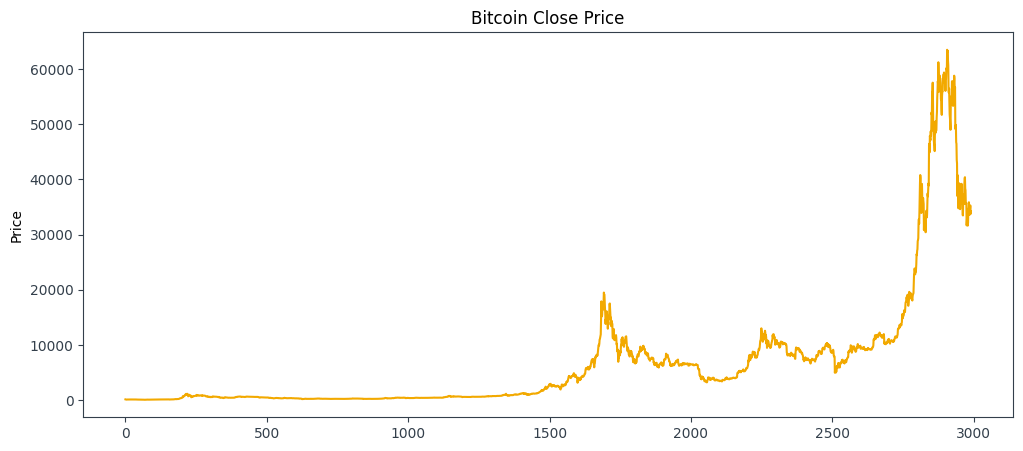

In [91]:
plt.figure(figsize=(12,5))
plt.plot(df['Close'])
plt.title("Bitcoin Close Price")
plt.ylabel("Price")
plt.show()


In [ ]:
adf_result = adfuller(df['Close'])
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")


ADF Statistic: -0.7973098451195634
p-value: 0.8199110033239144


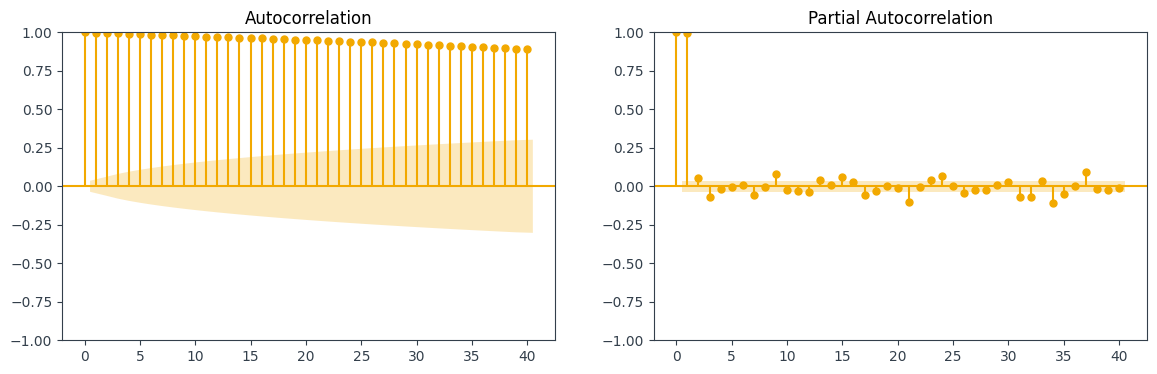

In [93]:
fig, ax = plt.subplots(1,2, figsize=(14,4))
plot_acf(df['Close'], lags=40, ax=ax[0])
plot_pacf(df['Close'], lags=40, ax=ax[1])
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


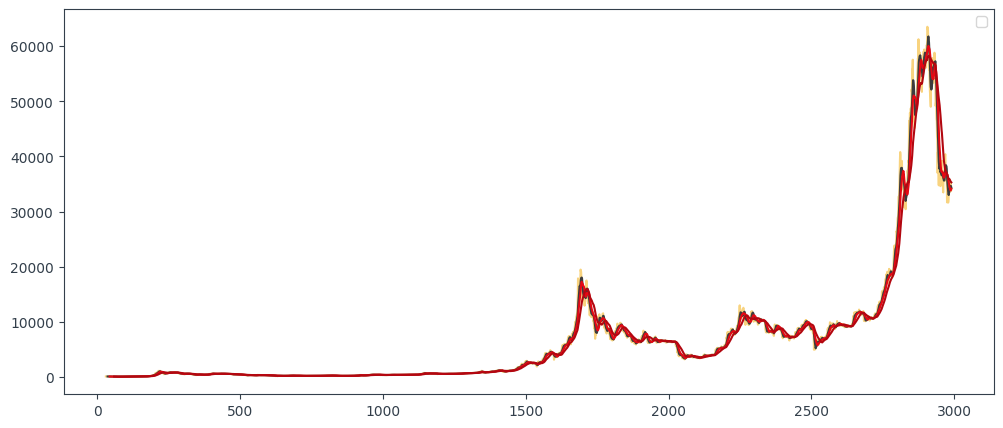

In [101]:
df['MA_7'] = df['Close'].rolling(7).mean()
df['MA_14'] = df['Close'].rolling(14).mean()
df['MA_30'] = df['Close'].rolling(30).mean()

plt.figure(figsize=(12,5))
plt.plot(df['Close'], alpha=0.5)
plt.plot(df['MA_7'])
plt.plot(df['MA_14'])
plt.plot(df['MA_30'])
plt.legend()
plt.show()


In [102]:
for lag in range(1, 31):
    df[f'lag_{lag}'] = df['Close'].shift(lag)


In [103]:
df['vol_7'] = df['Close'].rolling(7).std()
df['vol_14'] = df['Close'].rolling(14).std()
df['vol_30'] = df['Close'].rolling(30).std()

df.dropna(inplace=True)


In [104]:
train_size = int(len(df)*0.7)
val_size = int(len(df)*0.15)

train = df.iloc[:train_size]
val = df.iloc[train_size:train_size+val_size]
test = df.iloc[train_size+val_size:]


In [ ]:
features = [col for col in df.columns if col not in ['Close', 'Symbol', 'Name', 'Date', 'Coin_Name']]
features


['SNo',
 'High',
 'Low',
 'Open',
 'Volume',
 'Marketcap',
 'MA_7',
 'MA_14',
 'MA_30',
 'lag_1',
 'lag_2',
 'lag_3',
 'lag_4',
 'lag_5',
 'lag_6',
 'lag_7',
 'lag_8',
 'lag_9',
 'lag_10',
 'lag_11',
 'lag_12',
 'lag_13',
 'lag_14',
 'lag_15',
 'lag_16',
 'lag_17',
 'lag_18',
 'lag_19',
 'lag_20',
 'lag_21',
 'lag_22',
 'lag_23',
 'lag_24',
 'lag_25',
 'lag_26',
 'lag_27',
 'lag_28',
 'lag_29',
 'lag_30',
 'vol_7',
 'vol_14',
 'vol_30']

In [ ]:
train[features].info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2051 entries, 60 to 2110
Data columns (total 42 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   SNo        2051 non-null   int64  
 1   High       2051 non-null   float64
 2   Low        2051 non-null   float64
 3   Open       2051 non-null   float64
 4   Volume     2051 non-null   float64
 5   Marketcap  2051 non-null   float64
 6   MA_7       2051 non-null   float64
 7   MA_14      2051 non-null   float64
 8   MA_30      2051 non-null   float64
 9   lag_1      2051 non-null   float64
 10  lag_2      2051 non-null   float64
 11  lag_3      2051 non-null   float64
 12  lag_4      2051 non-null   float64
 13  lag_5      2051 non-null   float64
 14  lag_6      2051 non-null   float64
 15  lag_7      2051 non-null   float64
 16  lag_8      2051 non-null   float64
 17  lag_9      2051 non-null   float64
 18  lag_10     2051 non-null   float64
 19  lag_11     2051 non-null   float64
 20  lag_12 

In [ ]:
scaler = MinMaxScaler()
scaler.fit(train[features])


MinMaxScaler()

In [ ]:

X_train = scaler.transform(train[features])
X_val = scaler.transform(val[features])
X_test = scaler.transform(test[features])

y_train = train['Close']
y_val = val['Close']
y_test = test['Close']


#### Baseline Model 1 – Linear Regression

In [ ]:
lr = LinearRegression()
lr.fit(X_train, y_train)


LinearRegression()

In [ ]:
pred_lr = lr.predict(X_test)


#### Baseline Model 2 – Random Forest

In [111]:
rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=10,
    random_state=42
)


In [ ]:
rf.fit(X_train, y_train)


RandomForestRegressor(max_depth=10, n_estimators=200, random_state=42)

In [ ]:
pred_rf = rf.predict(X_test)


#### Baseline Model 3 – ARIMA

In [ ]:
arima = ARIMA(train['Close'], order=(5,1,2))
arima_fit = arima.fit()


In [ ]:
pred_arima = arima_fit.forecast(steps=len(test))


#### Evaluation metrics

In [ ]:
np.sqrt(mean_squared_error(y_test, pred_lr))


1.1082484625550926e-10

In [120]:
def evaluate(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    # direction = np.mean(np.sign(y_true.diff().dropna()) == np.sign(pd.Series(y_pred).diff().dropna()))
    return rmse, mae, mape


In [ ]:
evaluate(y_test, pred_arima)


(29238.647368392358, 23106.965864739435, nan)

In [123]:
results = []

results.append(["ARIMA", *evaluate(y_test, pred_arima)])
results.append(["Linear Regression", *evaluate(y_test, pred_lr)])
results.append(["Random Forest", *evaluate(y_test, pred_rf)])

results_df = pd.DataFrame(
    results,
    columns=["Model","RMSE","MAE","MAPE"]
)

results_df


,Model,RMSE,MAE,MAPE
0,ARIMA,2.923865e+04,2.310697e+04,NaN
1,Linear Regression,1.108248e-10,7.458681e-11,3.409760e-13
2,Random Forest,1.851394e+04,1.185303e+04,2.824673e+01


#### LSTM Model

In [124]:
def create_sequences(data, target, window=60):
    X, y = [], []
    for i in range(window, len(data)):
        X.append(data[i-window:i])
        y.append(target.iloc[i])
    return np.array(X), np.array(y)


In [125]:
window = 60

X_lstm, y_lstm = create_sequences(
    scaler.transform(df[features]),
    df['Close'],
    window
)

train_end = int(len(X_lstm)*0.7)
val_end = int(len(X_lstm)*0.85)

X_train_lstm, X_val_lstm, X_test_lstm = (
    X_lstm[:train_end],
    X_lstm[train_end:val_end],
    X_lstm[val_end:]
)

y_train_lstm, y_val_lstm, y_test_lstm = (
    y_lstm[:train_end],
    y_lstm[train_end:val_end],
    y_lstm[val_end:]
)


In [126]:
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(window, X_train_lstm.shape[2])),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')


In [127]:
es = EarlyStopping(patience=10, restore_best_weights=True)

history = model.fit(
    X_train_lstm, y_train_lstm,
    validation_data=(X_val_lstm, y_val_lstm),
    epochs=5,
    batch_size=32,
    callbacks=[es],
    verbose=1
)


Epoch 1/5
63/63 [==============================] - 5s 39ms/step - loss: 17902690.0000 - val_loss: 68971480.0000
Epoch 2/5
63/63 [==============================] - 2s 30ms/step - loss: 17879622.0000 - val_loss: 68931376.0000
Epoch 3/5
63/63 [==============================] - 2s 29ms/step - loss: 17868258.0000 - val_loss: 68896008.0000
Epoch 4/5
63/63 [==============================] - 2s 29ms/step - loss: 17857846.0000 - val_loss: 68862280.0000
Epoch 5/5
63/63 [==============================] - 2s 29ms/step - loss: 17847538.0000 - val_loss: 68828536.0000


In [128]:
pred_lstm = model.predict(X_test_lstm).flatten()

rmse, mae, mape = evaluate(
    pd.Series(y_test_lstm),
    pred_lstm
)

results_df.loc[len(results_df)] = [
    "LSTM", rmse, mae, mape
]

results_df


14/14 [==============================] - 1s 11ms/step


,Model,RMSE,MAE,MAPE
0,ARIMA,2.923865e+04,2.310697e+04,NaN
1,Linear Regression,1.108248e-10,7.458681e-11,3.409760e-13
2,Random Forest,1.851394e+04,1.185303e+04,2.824673e+01
3,LSTM,3.231741e+04,2.691091e+04,9.989255e+01


#### Multi-Step Forecasting (7 / 15 / 30 Days)

In [129]:
def forecast_future(model, last_sequence, steps):
    preds = []
    seq = last_sequence.copy()

    for _ in range(steps):
        pred = model.predict(seq.reshape(1,*seq.shape))[0,0]
        preds.append(pred)
        seq = np.vstack([seq[1:], seq[-1]])
    
    return preds


In [130]:
last_seq = X_lstm[-1]

forecast_7 = forecast_future(model, last_seq, 7)
forecast_15 = forecast_future(model, last_seq, 15)
forecast_30 = forecast_future(model, last_seq, 30)


1/1 [==============================] - 0s 26ms/step


#### Forecast Plots

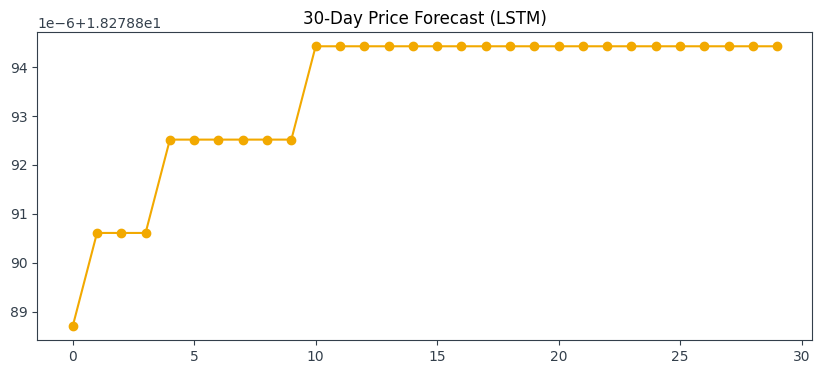

In [131]:
plt.figure(figsize=(10,4))
plt.plot(forecast_30, marker='o')
plt.title("30-Day Price Forecast (LSTM)")
plt.show()
